<a href="https://colab.research.google.com/github/hirohitokato/ohm_princess_pytorch/blob/main/Chapter2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pythonで機械学習入門機械学習入門(Pytorch版) **Chapter2**

In [3]:
!pip install torchviz
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=2064261a78b927a499d26f5ad08ceb1da0d57ca66a539abf074e90ac49daeff1
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim	# 最適化関数関係(from chainer import optimizers)
import torch.nn.functional as F	# 関数関係(import chainer.functions as F)
import torch.nn as nn	# ネットワーク関係(import chainer.links as L)

# デバッグ用途
from torchviz import make_dot
from torchinfo import summary

`from chainer import Variable, Chain, config` については以下のように扱う。。
* `Variable(np.ndarray)` : `torch.from_numpy(np.ndarray)`
* `class DNN(Chain):` : `class DNN(nn.Module):`
* `config.train = True` : **不明。要調査**

[公式のmigration_guide](https://chainer.github.io/migration-guide/)には次のように書いてある。

> Explains differences of how train/test modes are switched.
> * Chainer: This mode is controlled via a configuration (configuration.config.train).
> * PyTorch: This mode is a module state and should be changed using [torch.nn.Module.train(mode)](https://www.google.com/url?q=https://pytorch.org/docs/stable/nn.html%23torch.nn.Module.train&sa=D&source=editors&ust=1615451627944000&usg=AOvVaw1LtL0CCtZGBEHSHWobAyOG), [torch.nn.Module.eval()](https://www.google.com/url?q=https://pytorch.org/docs/stable/nn.html%23torch.nn.Module.eval&sa=D&source=editors&ust=1615451627944000&usg=AOvVaw1zTZQi3CLT-abAXb4xfMZp). This also means that you must pass the “train” argument to functions calls such as [torch.nn.functional.dropout](https://www.google.com/url?q=https://pytorch.org/docs/stable/nn.functional.html%23torch.nn.functional.dropout&sa=D&source=editors&ust=1615451627944000&usg=AOvVaw3WbrBYZ7GIbYZ3YU-g-QHz) otherwise use the [torch.nn.Dropout module](https://www.google.com/url?q=https://pytorch.org/docs/stable/nn.html%23torch.nn.Dropout&sa=D&source=editors&ust=1615451627945000&usg=AOvVaw17jwofkuPJvc55crtYQATG) which is stateful.
> * In both Chainer and PyTorch, train/test mode affects the behavior of certain functions/links/modules such as dropout and batch normalization.
> * Both Chainer and PyTorch default to train mode.

In [5]:
def f(x):
  y = x * x
  return y

In [6]:
D = 100
N = 2
xdata = np.random.randn(D*N).reshape(D,N).astype(np.float32)
tdata = (xdata[:,1]>f(xdata[:,0])).astype(np.int32)
xdata = torch.from_numpy(xdata).clone()
tdata = torch.from_numpy(tdata).clone()

In [7]:
# １層のニューラルネットワークを呼び出す
class MyNetwork(nn.Module):
  def __init__(self, in_features: int, out_features: int):
    super(MyNetwork, self).__init__()
    self.layer1 = nn.Linear(N,C)

C = 2
NN = MyNetwork(N,C)


In [8]:
def model(x):
  y = NN.layer1(x)
  return y

def F_accuracy(t,p):
    p_arg = torch.argmax(p,dim=1)
    return torch.sum(t == p_arg) / len(t)

In [9]:
# デバッグ。ネットワーク構造の可視化
# make_dot(ydata, dict(NN.named_parameters()))
# summary(NN)

## 確率的勾配降下法(SGD)の導入

単に上でネットワークを作っただけではいい加減な推論をするだけなので、確率的勾配降下法(SGD)を持ち込む。

In [10]:
optNN = optim.SGD(NN.parameters(), lr=0.0001, momentum=0.9)

In [11]:
loss_series = []
acc_series = []

T = 5000
tdata_long = tdata.to(torch.long)
for time in range(T):
  #NN.train()
  optNN.zero_grad()
  ydata = model(xdata)
  loss = F.cross_entropy(ydata, tdata_long)
  acc = F_accuracy(tdata.to(torch.int32), ydata)
  loss.backward()
  optNN.step()
  loss_series.append(loss.item())
  acc_series.append(acc.item())

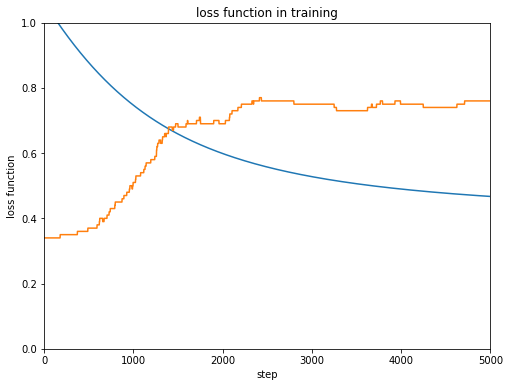

In [12]:
Tall = len(loss_series)
plt.figure(figsize=(8,6))
plt.plot(range(Tall), loss_series)
plt.plot(range(Tall), acc_series)
plt.title("loss function in training")
plt.xlabel("step")
plt.ylabel("loss function")
plt.xlim([0,Tall])
plt.ylim([0,1])
plt.show()

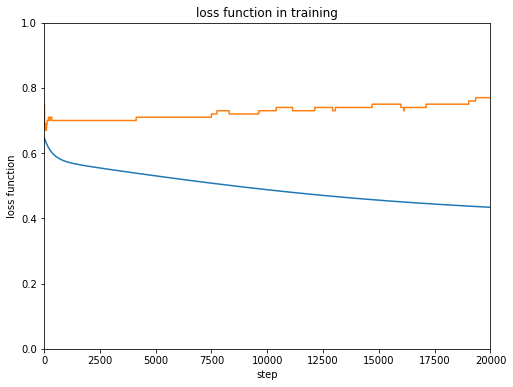

In [16]:
# ２層のネットワーク
class Network2(nn.Module):
  def __init__(self, in_features: int, out_features: int):
    super(Network2, self).__init__()
    self.layer1 = nn.Linear(N,N*4)
    self.layer2 = nn.Linear(N*4,C)
    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.activation(self.layer1(x))
    x = self.layer2(x)
    return x

NN2 = Network2(N,C)
optNN2 = optim.SGD(NN2.parameters(), lr=0.001)

loss_series = []
acc_series = []

criterion = nn.MSELoss()

T = 20000
tdata_long = tdata.to(torch.long)
for time in range(T):
  optNN2.zero_grad()
  ydata = NN2(xdata)
  
  loss = F.cross_entropy(ydata, tdata_long)
  acc = F_accuracy(tdata.to(torch.int32), ydata)
  loss.backward()
  optNN2.step()
  loss_series.append(loss.item())
  acc_series.append(acc.item())

# make_dot(ydata, dict(NN2.named_parameters()))

Tall = len(loss_series)
plt.figure(figsize=(8,6))
plt.plot(range(Tall), loss_series)
plt.plot(range(Tall), acc_series)
plt.title("loss function in training")
plt.xlabel("step")
plt.ylabel("loss function")
plt.xlim([0,Tall])
plt.ylim([0,1])
plt.show()